# Segmentation

Extract neuronal locations and planar time-traces.

- Apply the constrained nonnegative matrix factorization (CNMF) source separation algorithm to extract initial estimates of neuronal spatial footprints and calcium traces.
- Apply quality control metrics to evaluate the initial estimates, and narrow down to the final set of estimates.

## Caiman docs on component eval

https://caiman.readthedocs.io/en/latest/Getting_Started.html#component-evaluation

The quality of detected components is evaluated with three parameters:

**Spatial footprint consistency** `(rval)`: The spatial footprint of the component is compared with the frames where this component is active.

- Other component’s signals are subtracted from these frames, and the resulting raw data is correlated against the spatial component.
- This ensures that the raw data at the spatial footprint aligns with the extracted trace.

**Trace signal-noise-ratio** `SNR`: Peak SNR is calculated from strong calcium transients and the noise estimate.

**CNN-based classifier** `cnn`: The shape of components is evaluated by a 4-layered convolutional neural network trained on a manually annotated dataset.
- The CNN assigns a value of 0-1 to each component depending on its resemblance to a neuronal soma.

Each parameter has a low threshold:
- (rval_lowest (default -1), SNR_lowest (default 0.5), cnn_lowest (default 0.1))
and high threshold:
- (rval_thr (default 0.8), min_SNR (default 2.5), min_cnn_thr (default 0.9))
A component has to exceed ALL low thresholds as well as ONE high threshold to be accepted.

In [1]:
import os
from pathlib import Path
import logging

import mesmerize_core as mc
from mesmerize_core.caiman_extensions.cnmf import cnmf_cache

from caiman.source_extraction.cnmf import cnmf, params
from caiman.motion_correction import high_pass_filter_space
from caiman.summary_images import correlation_pnr

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import zarr
from ipywidgets import IntSlider, VBox
from sidecar import Sidecar

try:
    import cv2
    cv2.setNumThreads(0)
except():
    pass

if os.name == "nt":
    # disable the cache on windows, this will be automatic in a future version
    cnmf_cache.set_maxsize(0)

pd.options.display.max_colwidth = 120

# Unneeded in newer versions of mesmerize-core
os.environ['CONDA_PYTHON_EXE'] = "/home/flynn/miniforge3/bin/python"
os.environ['CONDA_PREFIX_1'] = "lcp"

logger = logging.getLogger("caiman")
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler()
log_format = logging.Formatter("%(relativeCreated)12d [%(filename)s:%(funcName)10s():%(lineno)s] [%(process)d] %(message)s")
handler.setFormatter(log_format)
logger.addHandler(handler)

logging.getLogger("caiman").setLevel(logging.WARNING)

2024-12-02 09:33:49.504908: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 09:33:49.523998: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data path setup

Data setup is similar to [motion_correction notebook](./motion_correction.ipynb).

You can make a new batch named something like `cnmf.batch` just like you did for registration.

However, you will want to also load the previous registration batch to use as input to `df.caiman.add_item()`.

Additionally, you will also want the path to the input file so we can read the metadata from the raw file.

Here, to keep data organized, we will:
1. define our previous analaysis path as `mcorr_batch_path`
2. create a new 'cnmf.pickle` to save our cnmf results.

In [2]:
parent_path = Path().home() / "caiman_data" / "out"
mcorr_batch_path = parent_path / 'batch.pickle'

mc.set_parent_raw_data_path(str(parent_path))

df_mcorr = mc.load_batch(mcorr_batch_path)
df_mcorr


,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,mcorr,plane_1.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",{'mean-projection-path': a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89/a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89_mean_projection.n...,2024-12-01T18:10:05,2024-12-01T18:13:10,170.19 sec,None,a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89
1,mcorr,plane_0,plane_21.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",{'mean-projection-path': 2918ff63-f204-4334-8837-ea172af89e39/2918ff63-f204-4334-8837-ea172af89e39_mean_projection.n...,2024-12-01T18:48:52,2024-12-01T18:52:57,172.63 sec,None,2918ff63-f204-4334-8837-ea172af89e39
2,mcorr,plane_2,plane_16.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",{'mean-projection-path': 245bb955-feb9-4245-86bf-dd6ec1c79e95/245bb955-feb9-4245-86bf-dd6ec1c79e95_mean_projection.n...,2024-12-01T18:48:52,2024-12-01T18:55:58,176.06 sec,None,245bb955-feb9-4245-86bf-dd6ec1c79e95


Item name cleanup

In [3]:
# fix our item names. Not needed but keeps things organized
df_mcorr.iloc[0].item_name = 'plane_1'
df_mcorr.iloc[1].item_name = 'plane_21'
df_mcorr.iloc[2].item_name = 'plane_16'
df_mcorr

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,plane_1,plane_1.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",{'mean-projection-path': a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89/a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89_mean_projection.n...,2024-12-01T18:10:05,2024-12-01T18:13:10,170.19 sec,None,a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89
1,mcorr,plane_21,plane_21.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",{'mean-projection-path': 2918ff63-f204-4334-8837-ea172af89e39/2918ff63-f204-4334-8837-ea172af89e39_mean_projection.n...,2024-12-01T18:48:52,2024-12-01T18:52:57,172.63 sec,None,2918ff63-f204-4334-8837-ea172af89e39
2,mcorr,plane_16,plane_16.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",{'mean-projection-path': 245bb955-feb9-4245-86bf-dd6ec1c79e95/245bb955-feb9-4245-86bf-dd6ec1c79e95_mean_projection.n...,2024-12-01T18:48:52,2024-12-01T18:55:58,176.06 sec,None,245bb955-feb9-4245-86bf-dd6ec1c79e95


Now a new batch set to store cnmf.

In [7]:
cnmf_batch_path = parent_path / 'cnmf.pickle'

# I like leaving `remove_existing` to False for safety, and if you want to "start over", just create a new batch by switching `remove_existing` to True.
df = mc.create_batch(cnmf_batch_path, remove_existing=False)
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid



- [get_input_movie_path()](https://mesmerize-core.readthedocs.io/en/latest/api/common.html#mesmerize_core.CaimanSeriesExtensions.get_input_movie_path) allows us to easily get filepaths to our raw files

In [8]:
from lbm_caiman_python import get_metadata
tiff_files = [df_mcorr.iloc[i].caiman.get_input_movie_path() for i in df_mcorr.index]
metadata = [get_metadata(file) for file in tiff_files]
print(metadata[0]['pixel_resolution'])
print(metadata[1]['pixel_resolution'])
print(metadata[2]['pixel_resolution'])

[1.04, 1.0]
[1.04, 1.0]
[1.04, 1.0]


## CNMF

Run the CaImAn `CNMF` algorithm using the mcorr output obtained in the last processing step.

### Initial parameters
In general in Caiman, estimators are first initialized with a set of parameters, and then they are fit against actual data in a separate step.

In this section, we'll define a `parameters` object that will subsequently be used to initialize our different estimators. 

| Parameter       | Description                                                                                                                                                                                                                                                                             | Default/Typical Value                        |
|------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------|
| `decay_time`    | Length of a typical transient in seconds. Approximation of the time scale for significant shifts in calcium signal. Defaults to `0.4` for fast indicators (e.g., GCaMP6f). Use `1` or more for slow indicators. Precise fitting is not necessary.                                       | 0.4 (fast indicators)                       |
| `p`             | Order of the autoregressive model. Use `p=0` to turn off deconvolution. Set `p=1` for instantaneous transients (e.g., low sample rate or slow indicator). Set `p=2` for visible rise time transients. Incorrect order leads to unreliable spike extraction.                              | 1 (slow), 2 (visible rise time)             |
| `nb`            | Number of global background components. Defaults to `2` for relatively homogeneous backgrounds. Use `3` for more complex noise, `1` is usually too low. Too low `nb` causes noisy traces; too high absorbs neuronal signals, reducing transients.                                       | 2                                           |
| `merge_thr`     | Merging threshold for components after initialization. Components correlated above this threshold are merged, useful for splitting neurons during initialization.                                                                                                                       | Typically between 0.7 and 0.9               |
| `rf`            | Half-size of patches in pixels. Should be at least 3–4 times larger than neuron size to capture the neuron and local background. Larger patches reduce parallelization.                                                                                                                | 3–4 × expected neuron size                  |
| `stride`        | Overlap between patches in pixels. Typically set to neuron diameter. Larger values increase computational load but improve reconstruction/denoising.                                                                                                                                | Neuron diameter (~10–20 pixels)             |
| `K`             | Expected number of components per patch. Adjust based on patch size (`rf`) and component density.                                                                                                                                                                                     | Varies based on data                        |
| `gSig`          | Expected half-size of neurons in pixels `[rows X columns]`. This is a **crucial** parameter for accurate component detection.                                                                                                                                                        | Typically matches neuron half-size          |
| `method_init`   | Initialization method. Depends on the recording method: use `greedy_roi` for 2p data, `corr_pnr` for 1p data, and `sparse_nmf` for dendritic/axonal data.                                                                                                                              | `greedy_roi`, `corr_pnr`, `sparse_nmf`      |
| `ssub/tsub`     | Spatial and temporal subsampling during initialization. Defaults to `1` (no compression). Increase (e.g., `2` or more) to save resources but at the potential cost of impaired detection/extraction quality.                                                                           | 1 (no compression), 2+ (for resource saving)|

`decay_time`: Length of a typical transient in seconds. decay_time is an approximation of the time scale over which to expect a significant shift in the calcium signal during a transient. It defaults to 0.4, which is appropriate for fast indicators (GCaMP6f), slow indicators might use 1 or even more. However, decay_time does not have to precisely fit the data, approximations are enough.

[Decay times](https://www.janelia.org/jgcamp8-calcium-indicators)

| Protein            | Max dF/F   | Half-rise time (ms)   | Time to peak (ms)   | Half-decay time (ms)   |
|:-------------------|:-----------|:----------------------|:--------------------|:-----------------------|
| jGCaMP7f (control) | 0.21±0.1   | 24.8±6.6              | 99.5±30.2           | 181.9±76.0             |
| jGCaMP8f           | 0.41±0.12  | 7.1±0.74              | 24.8±6.1            | 67.4±11.2              |
| jGCaMP8m           | 0.76±0.22  | 7.1±0.61              | 29.0±11.2           | 118.3±13.2             |
| jGCaMP8s           | 1.11±0.22  | 10.1±0.86             | 57.0±12.9           | 306.7±32.2             |
| jGCaMP8.712*       | 0.66±0.18  | 10.9±1.24             | 41.6±8.1            | 94.8±13.3              |

#### A note on strides and overlaps

For registration, the `strides` and `overlaps` have influence on the quality of the results as each patch is processed individually and merged.

For segmentation, the equivalent `stride` and `rf` parameters (yes, confusing) only influence the processing time and not the qualty of the result.

`gSig` is arguably the most influencial parameter, it should be the size of your neurons in `um` * 2.

- if your typical neuron is `14um`, `gSig` should be around 6-10.

In [10]:
gSig = 7  # Set this to half the size of your neuron, so 7 um for an approximate neuron size of 12-15um. See motion_correction.ipynb for a visualization helping you determine this value.

# parameters for component evaluation
min_SNR = 1.4               # signal to noise ratio for accepting a component
rval_thr = 0.80             # space correlation threshold for accepting a component

params_cnmf =\
{
    "main":
    {
        'fr': metadata[0]['frame_rate'],
        'use_cnn': False,                       # Will error if you set this to True without downloading the CNN model via caimanmanager install
        'dxy': metadata[0]['pixel_resolution'],
        'method_init': 'greedy_roi',  # could also try 'corr_pnr'
        'K': 50,
        'gSig': (gSig, gSig),
        'gSiz': (4 * gSig + 1, 4 * gSig + 1),
        'merge_thr': 0.7,
        'p': 2,
        'tsub': 1,
        'ssub': 1,
        'rf': 30,
        'stride': 12,
        'method_deconvolution': 'oasis',       # could use 'cvxpy' alternatively
        'low_rank_background': None,
        'update_background_components': True,  # defaults true, sometimes setting to False improve the results
        # 'ring_size_factor': 1.4,             # if attempting CNMFE, this is the radius of ring (*gSig) for computing background during corr_pnr
        'del_duplicates': True,                # whether to remove duplicates from initialization
        'min_SNR': min_SNR,
        'rval_thr': rval_thr,
    }
}

`min_SNR` and `rval_thr` can be tuned with `mesmerize-viz` after processing is complete.

# Run CNMF

The API is identical to running mcorr.

You can provide the mcorr item row to `input_movie_path` and it will resolve the path of the input movie from the entry in the DataFrame.

In [11]:
df = df.caiman.reload_from_disk()

df.caiman.add_item(
    algo='cnmf',
    input_movie_path=df_mcorr.iloc[0], # our registration results row
    params=params_cnmf,
    item_name=f'{df_mcorr.iloc[0].item_name}_cnmf',
)

In [12]:
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,cnmf,plane_1_cnmf,a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89/a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89-plane_1_els__d1_600_d2_576_d3_1_order_F_fr...,"{'main': {'fr': 9.60806, 'use_cnn': False, 'dxy': (1.04, 1.0), 'method_init': 'greedy_roi', 'K': 50, 'gSig': (7, 7),...",None,2024-12-02T09:41:03,None,None,None,55ee2c5b-cbc8-4fe3-b816-628fca029fba


In [ ]:
df.iloc[-1].caiman.run()

************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                                plane_1_cnmf
input_movie_path    a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89/a8f0f15d-...
params              {'main': {'fr': 9.60806, 'use_cnn': False, 'dx...
outputs                                                          None
added_time                                        2024-12-02T09:41:03
ran_time                                                         None
algo_duration                                                    None
comments                                                         None
uuid                             55ee2c5b-cbc8-4fe3-b816-628fca029fba
Name: 0, dtype: object
With params:{'main': {'fr': 9.60806, 'use_cnn': False, 'dxy': (1.04, 1.0), 'method_init': 'greedy_roi', 'K': 50, 'gSig': (7, 7), 'gSiz': (29, 29), 'merge_thr': 0.7, 'p': 2, 'tsub': 1,

The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


making memmap


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


## Checking for an errors

After a batch run, check the results to make sure the outputs do not contain a "traceback" error.

In [30]:
import pprint
df = df.caiman.reload_from_disk()
pprint.pprint(df.iloc[-1].outputs["traceback"])

{'main': {'K': 50,
          'del_duplicates': True,
          'dxy': (1.04, 1.0),
          'fr': 9.60806,
          'gSig': (7, 7),
          'gSiz': (29, 29),
          'low_rank_background': None,
          'merge_thr': 0.7,
          'method_deconvolution': 'oasis',
          'method_init': 'greedy_roi',
          'p': 2,
          'rf': 30,
          'ssub': 1,
          'stride': 12,
          'tsub': 1,
          'update_background_components': True,
          'use_cnn': False}}


In [34]:
df = df.caiman.reload_from_disk()
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,cnmf,cnmf,a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89/a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89-plane_1_els__d1_600_d2_576_d3_1_order_F_fr...,"{'main': {'fr': 9.60806, 'dxy': [1.04, 1.0], 'method_init': 'greedy_roi', 'K': None, 'gSig': (7, 7), 'gSiz': (29, 29...","{'success': False, 'traceback': 'multiprocessing.pool.RemoteTraceback: """""" Traceback (most recent call last): Fil...",2024-12-01T20:00:10,2024-12-01T20:09:18,7.49 sec,None,eb941231-c6c1-4d5c-929f-bdf261b0d1b2
1,cnmf,cnmf,a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89/a8f0f15d-d2a7-4ab8-92d1-9dc05ebcbc89-plane_1_els__d1_600_d2_576_d3_1_order_F_fr...,"{'main': {'fr': 9.60806, 'dxy': (1.04, 1.0), 'method_init': 'greedy_roi', 'K': 50, 'gSig': (7, 7), 'gSiz': (29, 29),...","{'success': False, 'traceback': 'Traceback (most recent call last): File ""/home/flynn/miniforge3/envs/lbm/lib/pyth...",2024-12-01T20:55:39,2024-12-01T23:04:16,530.22 sec,None,9bc0340b-0d0e-4119-b86b-f9aa8b5ccc01


In [33]:
df.caiman.remove_item(2)

# CNMF outputs

Similar to mcorr, you can use the `mesmerize-core` API to fetch the outputs.

[API reference for mesmerize-CNMF](https://mesmerize-core.readthedocs.io/en/latest/api/cnmf.html)
[API reference for caiman-CNMF](https://caiman.readthedocs.io/en/latest/Getting_Started.html#parameters)



## CNMF Object

In [4]:
mcorr_movie = df.iloc[0].mcorr.get_output()
cnmf_model = df.iloc[-1].cnmf.get_output()

In [7]:
num_traces = cnmf_model.estimates.C
num_traces.shape

(8533, 1730)

In [17]:
gSig = 3
corr, pnr = correlation_pnr(mcorr_movie[::2], gSig=gSig, swap_dim=False)

# Interactive Parameter Exploration

In [ ]:
from ipywidgets import Tab, Text, Button, VBox, interact_manual, interactive
@interact_manual(parent_path=str(parent_path), batch_path=str(batch_path))
def start_widget(parent_path, batch_path):
    mc.set_parent_raw_data_path(parent_path)

    df = mc.load_batch(batch_path)

    tab = Tab()

    # mcorr_container = df.mcorr.viz(start_index=0)
    cnmf_container = df.cnmf.viz(start_index=19)

    tab.children = [cnmf_container.show()]
    tab.titles = ["cnmf"]
    display(tab)

## Temporal components, residuals

In [ ]:
index = -1  # the last item added

rcb = df.iloc[index].cnmf.get_rcb()
residuals = df.iloc[index].cnmf.get_residuals()
input_movie = df.iloc[index].caiman.get_input_movie()

# temporal components
temporal = df.iloc[index].cnmf.get_temporal()

temporal_good = df.iloc[index].cnmf.get_temporal("good")
temporal_bad = df.iloc[index].cnmf.get_temporal("bad")

temporal_with_residuals = df.iloc[index].cnmf.get_temporal(add_residuals=True)

correlation_image = df.iloc[-1].caiman.get_corr_image()

components_good = df.iloc[-1].cnmf.get_good_components()
components_bad = df.iloc[-1].cnmf.get_bad_components()

mean_img = df.iloc[-1].caiman.get_projection('mean')
std_img = df.iloc[-1].caiman.get_projection('std')

masks = df.iloc[-1].cnmf.get_masks()

print(f'Temporal Components (good/bad): {temporal_good.shape} / {temporal_bad.shape}')
print(f'Spatial Components (good/bad): {components_good.shape} / {components_bad.shape}')

In [9]:
good_masks = df.iloc[-1].cnmf.get_masks('good')
bad_masks = df.iloc[-1].cnmf.get_masks('bad')

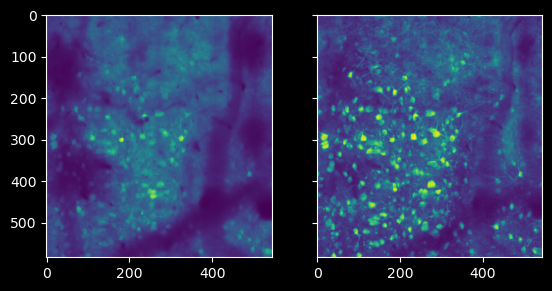

In [95]:
fig, ax = plt.subplots(1,2, sharey=True)
ax[0].imshow(mean_img)
ax[1].imshow(correlation_image)

In [ ]:
cnmf_model.params

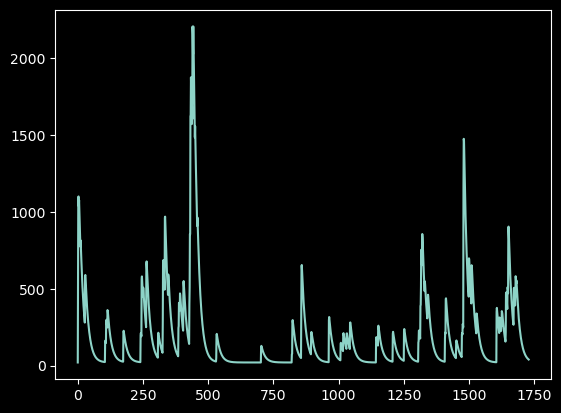

In [11]:
# dim order: txy[,z]
plt.plot(cnmf_model.estimates.C[3,:])
plt.show()

Many of the cnmf functions take a rich set of arguments

### Get specific components

In [12]:
df.iloc[-1].cnmf.get_temporal(np.array([1, 5, 9]))

array([[ 114.17567548, 1109.50506026, 1065.47162328, ...,  402.61607549,
         348.24701629,  304.12614734],
       [  45.03461595,   45.03461595,   45.03461595, ...,  132.04335154,
         126.66286509,  121.61509965],
       [   0.        ,  358.81892873,  391.91603586, ...,  270.95206299,
         256.85871484,  243.49842054]])

### add risiduals / contours

In [ ]:
# get temporal with the residuals, i.e. C + YrA
temporal_with_residuals = df.iloc[index].cnmf.get_temporal(add_residuals=True)

viewer = napari.Viewer()
viewer.add_image(temporal_with_residuals, name='traces+residuals')

In [73]:
# get contours
contours = df.iloc[-1].cnmf.get_contours()
len(contours)

2

In [ ]:
viz_cnmf = df.cnmf.viz()
viz_cnmf.show()

Returns: `(list of np.ndarray of contour coordinates, list of center of mass)`

In [33]:
# get_contours() also takes arguments
contours_good = df.iloc[index].cnmf.get_contours("good")
len(contours_good[0]) # number of contours

swap_dim

In [12]:
# get the first contour using swap_dim=True (default)
swap_dim_true = df.iloc[index].cnmf.get_contours()[0][0]
# get the first contour  with swap_dim=False
swap_dim_false = df.iloc[index].cnmf.get_contours(swap_dim=False)[0][0]

plt.plot(
    swap_dim_true[:, 0],
    swap_dim_true[:, 1],
    label="swap_dim=True"
)
plt.plot(
    swap_dim_false[:, 0],
    swap_dim_false[:, 1],
    label="swap_dim=False"
)
plt.legend()

# swap_dim swaps the x and y dims
plt.plot(
    swap_dim_true[:, 0],
    swap_dim_true[:, 1],
    linewidth=30
)
plt.plot(
    swap_dim_false[:, 1],
    swap_dim_false[:, 0],
    linewidth=10
)

# Reconstructed movie - `A * C`
# Reconstructed background - `b * f`
# Residuals - `Y - AC - bf` 

Mesmerize-core provides these outputs as lazy arrays. This allows you to work with arrays that would otherwise be hundreds of gigabytes or terabytes in size.

In [ ]:
rcm = df.iloc[index].cnmf.get_rcm()
rcm

# Using LazyArrays

In [16]:
rcm_accepted = df.iloc[index].cnmf.get_rcm("good")
rcm_rejected = df.iloc[index].cnmf.get_rcm("bad")

rcb = df.iloc[index].cnmf.get_rcb()
residuals = df.iloc[index].cnmf.get_residuals()
input_movie = df.iloc[index].caiman.get_input_movie()

In [ ]:
rcb.shape

In [ ]:
napari.view_image(rcb)

# Parameter Gridsearch

As shown for motion correction, the purpose of `mesmerize-core` is to perform parameter searches

In [8]:
# itertools.product makes it easy to loop through parameter variants
# basically, it's easier to read that deeply nested for loops
from copy import deepcopy
from itertools import product

# variants of several parameters
gSig_variants = [4, 6]
K_variants = [4, 8]
merge_thr_variants = [0.8, 0.95]

# always use deepcopy like before
new_params_cnmf = deepcopy(params_cnmf)

# create a parameter grid
parameter_grid = product(gSig_variants, K_variants, merge_thr_variants)

# a single for loop to go through all the various parameter combinations
for gSig, K, merge_thr in parameter_grid:
    # deep copy params dict just like before
    new_params_cnmf = deepcopy(new_params_cnmf)

    new_params_cnmf["main"]["gSig"] = [gSig, gSig]
    new_params_cnmf["main"]["K"] = K
    new_params_cnmf["main"]["merge_thr"] = merge_thr

    # add param combination variant to batch
    df.caiman.add_item(
        algo="cnmf",
        item_name=df.iloc[1]["item_name"],  # good mcorr item
        input_movie_path=df.iloc[1],
        params=new_params_cnmf
    )

## Pull contours / good components

In [ ]:
row_ix = 1
# get the contours and center of masses using mesmerize_core
contours, coms = df.iloc[row_ix].cnmf.get_contours(component_indices="good", swap_dim=False)

# get the signal-to-noise ratio of each "good" component to color components
snr_comps = df.iloc[row_ix].cnmf.get_output().estimates.SNR_comp

# get the good component_ixs
good_ixs = df.iloc[row_ix].cnmf.get_good_components()

# only get snr_comps of good_ixs
snr_comps = snr_comps[good_ixs]

np.log10(snr_comps)[:10]

View the diffs

In [9]:
df.caiman.get_params_diffs(algo="cnmf", item_name=df.iloc[-1]["item_name"])

,merge_thr,K,gSig
3,0.8,4,"(4, 4)"
4,0.95,4,"(4, 4)"
5,0.8,8,"(4, 4)"
6,0.95,8,"(4, 4)"
7,0.8,4,"(6, 6)"
8,0.95,4,"(6, 6)"
9,0.8,8,"(6, 6)"
10,0.95,8,"(6, 6)"


# Run the `cnmf` batch items

In [10]:
for i, row in df.iterrows():
    if row["outputs"] is not None: # item has already been run
        continue # skip

    process = row.caiman.run()

    # on Windows you MUST reload the batch dataframe after every iteration because it uses the `local` backend.
    # this is unnecessary on Linux & Mac
    # "DummyProcess" is used for local backend so this is automatic
    if process.__class__.__name__ == "DummyProcess":
        df = df.caiman.reload_from_disk()

Running 5cb543ec-5358-4b35-83cf-bfd19fa06a68 with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                 extracted_plane_1
input_movie_path    b32f41bf-a9a5-4965-be7c-e6779e854328\b32f41bf-a9a5-4965-be7c-e6779e854328-extracted_plane_1_els__d1_583_d2_536_d3_1_...
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'strides': (48, 48), 'overlaps': (24, 24), 'max_shifts':...
outputs                                                                                                                                None
added_time                                                                                                              2024-09-27T14:48:59
ra

    16876777 [cluster.py:setup_cluster():225] [16612] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    16876888 [params.py:change_params():1151] [16612] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
    16880718 [paths.py:get_tempdir():46] [16612] Default temporary dir C:\Users\RBO\caiman_data\temp does not exist, creating


making memmap


    16890809 [cluster.py:setup_cluster():225] [16612] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval
Running df52a609-d986-4bc0-a0a2-526cbfda057d with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                 extracted_plane_1
input_movie_path    b32f41bf-a9a5-4965-be7c-e6779e854328\b32f41bf-a9a5-4965-be7c-e6779e854328-extracted_plane_1_els__d1_583_d2_536_d3_1_...
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'strides': (48, 48), 'overlaps': (24, 24), 'max_shifts':...
outputs                                                                                                                                None
added_time                                                                           

    16956929 [cluster.py:setup_cluster():225] [16612] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    16957033 [params.py:change_params():1151] [16612] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


making memmap


    16967754 [cluster.py:setup_cluster():225] [16612] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval
Running f38614e3-d632-434a-9721-290aceeb4907 with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                 extracted_plane_1
input_movie_path    b32f41bf-a9a5-4965-be7c-e6779e854328\b32f41bf-a9a5-4965-be7c-e6779e854328-extracted_plane_1_els__d1_583_d2_536_d3_1_...
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'strides': (48, 48), 'overlaps': (24, 24), 'max_shifts':...
outputs                                                                                                                                None
added_time                                                                           

    17032862 [cluster.py:setup_cluster():225] [16612] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    17032966 [params.py:change_params():1151] [16612] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


making memmap


    17043554 [cluster.py:setup_cluster():225] [16612] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images


# Load outputs

In [16]:
df = df.caiman.reload_from_disk()
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,extracted_plane_1,tiff\extracted_plane_1.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': b32f41bf-a9a5-4965-be7c-e6779e854328\b32f41bf-a9a5-4965-be7c-e6779e854328_mean_projection.n...,2024-09-26T11:56:54,2024-09-26T12:02:55,77.3 sec,None,b32f41bf-a9a5-4965-be7c-e6779e854328
1,cnmf,cnmf_1,b32f41bf-a9a5-4965-be7c-e6779e854328\b32f41bf-a9a5-4965-be7c-e6779e854328-extracted_plane_1_els__d1_583_d2_536_d3_1_...,"{'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'strides': (48, 48), 'overlaps': (24, 24), 'max_shifts':...",{'mean-projection-path': a057e39e-a2df-41d3-8217-83c9cd7ffb6d\a057e39e-a2df-41d3-8217-83c9cd7ffb6d_mean_projection.n...,2024-09-26T16:26:20,2024-09-26T16:28:48,143.18 sec,None,a057e39e-a2df-41d3-8217-83c9cd7ffb6d
2,cnmf,cnmf_1,b32f41bf-a9a5-4965-be7c-e6779e854328\b32f41bf-a9a5-4965-be7c-e6779e854328-extracted_plane_1_els__d1_583_d2_536_d3_1_...,"{'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...",{'mean-projection-path': 0d8d3234-eab7-4f90-9405-53a2ad7917dc\0d8d3234-eab7-4f90-9405-53a2ad7917dc_mean_projection.n...,2024-10-01T12:09:56,2024-10-01T12:26:42,996.44 sec,None,0d8d3234-eab7-4f90-9405-53a2ad7917dc
3,mcorr,plane_1,tiff\extracted_plane_1.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': c220fb8a-cef9-4784-91a2-84f33d760b75\c220fb8a-cef9-4784-91a2-84f33d760b75_mean_projection.n...,2024-10-01T13:24:33,2024-10-01T13:28:06,83.34 sec,None,c220fb8a-cef9-4784-91a2-84f33d760b75
4,mcorr,plane_2,tiff\extracted_plane_2.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': ecdbaa07-8893-4352-8658-19a8357306b8\ecdbaa07-8893-4352-8658-19a8357306b8_mean_projection.n...,2024-10-01T13:24:33,2024-10-01T13:29:29,83.69 sec,None,ecdbaa07-8893-4352-8658-19a8357306b8
5,mcorr,plane_3,tiff\extracted_plane_3.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': 48bad9bd-8a15-4d42-ae64-cb199ff498bc\48bad9bd-8a15-4d42-ae64-cb199ff498bc_mean_projection.n...,2024-10-01T13:24:33,2024-10-01T13:30:53,83.81 sec,None,48bad9bd-8a15-4d42-ae64-cb199ff498bc
6,mcorr,plane_4,tiff\extracted_plane_4.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': 29217cfc-8575-4c35-b8b0-2fb29a4cb416\29217cfc-8575-4c35-b8b0-2fb29a4cb416_mean_projection.n...,2024-10-01T13:24:33,2024-10-01T13:32:17,82.93 sec,None,29217cfc-8575-4c35-b8b0-2fb29a4cb416
7,mcorr,plane_5,tiff\extracted_plane_5.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': f9e87c87-913e-4027-a3bd-83c4c7182493\f9e87c87-913e-4027-a3bd-83c4c7182493_mean_projection.n...,2024-10-01T13:24:33,2024-10-01T13:33:39,82.31 sec,None,f9e87c87-913e-4027-a3bd-83c4c7182493
8,mcorr,plane_6,tiff\extracted_plane_6.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': baf9fc6a-9159-46fd-a6b8-603d02c30c99\baf9fc6a-9159-46fd-a6b8-603d02c30c99_mean_projection.n...,2024-10-01T13:24:33,2024-10-01T13:35:02,82.48 sec,None,baf9fc6a-9159-46fd-a6b8-603d02c30c99
9,mcorr,plane_7,tiff\extracted_plane_7.tif,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': 7afd6d4c-7787-4e02-8dfc-fd0ce578164d\7afd6d4c-7787-4e02-8dfc-fd0ce578164d_mean_projection.n...,2024-10-01T13:24:33,2024-10-01T13

In [36]:
cnmf_params_all = df.iloc[2].params
cnmf_params_all

{'main': {'fr': 9.62,
  'dxy': (1.0, 1.0),
  'decay_time': 0.4,
  'p': 2,
  'nb': 1,
  'rf': 40,
  'K': 150,
  'gSig': array([7.5, 7.5]),
  'stride': 10,
  'method_init': 'greedy_roi',
  'rolling_sum': True,
  'use_cnn': False,
  'ssub': 1,
  'tsub': 1,
  'merge_thr': 0.8,
  'bas_nonneg': True,
  'min_SNR': 1.4,
  'rval_thr': 0.8},
 'refit': True}

In [4]:
cnmf_batch = parent_path / 'results'
cnmf_batch.mkdir(exist_ok=True, parents=True)

In [5]:
cnmf_batch = mc.load_batch(cnmf_batch / 'cnmf_batch.pickle')
cnmf_batch

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,cnmf,cnmf_1,tiff\extracted_plane_1.tif,"{'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...",{'mean-projection-path': faeb27e8-40b9-4e5a-ad8c-b9cc73c03635\faeb27e8-40b9-4e5a-ad8c-b9cc73c03635_mean_projection.n...,2024-10-01T16:34:44,2024-10-01T16:54:16,946.94 sec,None,faeb27e8-40b9-4e5a-ad8c-b9cc73c03635
1,cnmf,cnmf_1,tiff\extracted_plane_2.tif,"{'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...",{'mean-projection-path': 89b676c7-9480-47d7-b190-e4bbc2a5decc\89b676c7-9480-47d7-b190-e4bbc2a5decc_mean_projection.n...,2024-10-01T16:34:44,2024-10-01T17:10:06,949.6 sec,None,89b676c7-9480-47d7-b190-e4bbc2a5decc
2,cnmf,cnmf_1,tiff\extracted_plane_3.tif,"{'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...",{'mean-projection-path': f03ead24-ab13-48e7-87c0-27d5940a7c91\f03ead24-ab13-48e7-87c0-27d5940a7c91_mean_projection.n...,2024-10-01T16:34:44,2024-10-01T17:28:57,1131.04 sec,None,f03ead24-ab13-48e7-87c0-27d5940a7c91
3,cnmf,cnmf_1,tiff\extracted_plane_4.tif,"{'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...",{'mean-projection-path': 585a0fc2-40d4-45f2-badf-ba13d5cc77a6\585a0fc2-40d4-45f2-badf-ba13d5cc77a6_mean_projection.n...,2024-10-01T16:34:44,2024-10-01T17:51:18,1340.32 sec,None,585a0fc2-40d4-45f2-badf-ba13d5cc77a6
4,cnmf,cnmf_1,tiff\extracted_plane_5.tif,"{'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...",{'mean-projection-path': 544c2a52-0b90-4b74-baae-b2ca913c7c2a\544c2a52-0b90-4b74-baae-b2ca913c7c2a_mean_projection.n...,2024-10-01T16:34:44,2024-10-01T18:08:22,1024.35 sec,None,544c2a52-0b90-4b74-baae-b2ca913c7c2a
5,cnmf,cnmf_1,tiff\extracted_plane_6.tif,"{'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...",{'mean-projection-path': d6c3f33c-2b90-4c6d-a4ad-f237dae5f73b\d6c3f33c-2b90-4c6d-a4ad-f237dae5f73b_mean_projection.n...,2024-10-01T16:34:44,2024-10-01T18:24:00,937.73 sec,None,d6c3f33c-2b90-4c6d-a4ad-f237dae5f73b
6,cnmf,cnmf_1,tiff\extracted_plane_7.tif,"{'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...",{'mean-projection-path': ca269a68-06d0-4f96-b508-87160fdf37ab\ca269a68-06d0-4f96-b508-87160fdf37ab_mean_projection.n...,2024-10-01T16:34:44,2024-10-01T18:39:39,939.58 sec,None,ca269a68-06d0-4f96-b508-87160fdf37ab
7,cnmf,cnmf_1,tiff\extracted_plane_8.tif,"{'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...",{'mean-projection-path': a9cb2077-073a-4552-9669-e53ba0c96803\a9cb2077-073a-4552-9669-e53ba0c96803_mean_projection.n...,2024-10-01T16:34:44,2024-10-01T18:55:09,929.57 sec,None,a9cb2077-073a-4552-9669-e53ba0c96803
8,cnmf,cnmf_1,tiff\extracted_plane_9.tif,"{'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...",{'mean-projection-path': c0205f69-ccb6-4304-9cee-18af09d11663\c0205f69-ccb6-4304-9cee-18af09d11663_mean_projection.n...,2024-10-01T16:34:44,2024-10-01T19:10:49,940.35 sec,None,c0205f69-ccb6-4304-9cee-18af09d11663
9,cnmf,cnmf_1,tiff\extracted_plane_10.tif,"{'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...",{'mean-projection-path': 1fac642d-6cef-4a68-9415-737213b4462d\1fac642d-6cef-4a68-9415-737213b4462d_mean_projection.n...,2024-10-01T16:34:44,2024-10-01T19:28:15,1045.02 sec,None,1fac642d-6cef-4a68-9415-737213b4462d


In [37]:
for i in range(1, 31):
    item_name_str = df.iloc[i]['item_name']
    if 'plane' in item_name_str:

        filename = f'extracted_{item_name_str}.tif'
        filepath = parent_path / 'tiff' / filename
        # find output that matches item_name_str
        cnmf_batch.caiman.add_item(
            algo='cnmf',
            input_movie_path=filepath,
            params=cnmf_params_all,
            item_name=f'cnmf_1',
        )

In [1]:
cnmf_batch = cnmf_batch.caiman.reload_from_disk()
cnmf_batch

NameError: name 'cnmf_batch' is not defined

In [40]:
for i, row in cnmf_batch.iterrows():
    if row["outputs"] is not None:
        continue

    process = row.caiman.run()

    # on Windows you MUST reload the batch dataframe after every iteration because it uses the `local` backend.
    # this is unnecessary on Linux & Mac
    # "DummyProcess" is used for local backend so this is automatic
    if process.__class__.__name__ == "DummyProcess":
        df = cnmf_batch.caiman.reload_from_disk()

Running faeb27e8-40b9-4e5a-ad8c-b9cc73c03635 with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                 tiff\extracted_plane_1.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                                                              2024-10-01T16:34:44
ra

    12963988 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    12964133 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_1.tif'> shaped series axes do not match shape


making memmap


    12977206 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval


    13904154 [estimates.py:evaluate_components():1060] [16596] NaN values detected for space correlation in [8875]. Changing their value to -1.


Running 89b676c7-9480-47d7-b190-e4bbc2a5decc with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                 tiff\extracted_plane_2.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                                                              2024-10-01T16:34:44
ra

    13910972 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    13911069 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_2.tif'> shaped series axes do not match shape


making memmap


    13924222 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval
Running f03ead24-ab13-48e7-87c0-27d5940a7c91 with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                 tiff\extracted_plane_3.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                           

    14860679 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    14860787 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_3.tif'> shaped series axes do not match shape


making memmap


    14873610 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval
Running 585a0fc2-40d4-45f2-badf-ba13d5cc77a6 with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                 tiff\extracted_plane_4.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                           

    15991797 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    15991909 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_4.tif'> shaped series axes do not match shape


making memmap


    16004684 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval
Running 544c2a52-0b90-4b74-baae-b2ca913c7c2a with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                 tiff\extracted_plane_5.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                           

    17332164 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    17332271 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_5.tif'> shaped series axes do not match shape


making memmap


    17344985 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval


    18349840 [estimates.py:evaluate_components():1060] [16596] NaN values detected for space correlation in [8732]. Changing their value to -1.


Running d6c3f33c-2b90-4c6d-a4ad-f237dae5f73b with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                 tiff\extracted_plane_6.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                                                              2024-10-01T16:34:44
ra

    18356589 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    18356697 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_6.tif'> shaped series axes do not match shape


making memmap


    18369597 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval


    19287618 [estimates.py:evaluate_components():1060] [16596] NaN values detected for space correlation in [8801]. Changing their value to -1.


Running ca269a68-06d0-4f96-b508-87160fdf37ab with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                 tiff\extracted_plane_7.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                                                              2024-10-01T16:34:44
ra

    19294349 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    19294490 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_7.tif'> shaped series axes do not match shape


making memmap


    19307355 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval


    20226922 [estimates.py:evaluate_components():1060] [16596] NaN values detected for space correlation in [8772]. Changing their value to -1.


Running a9cb2077-073a-4552-9669-e53ba0c96803 with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                 tiff\extracted_plane_8.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                                                              2024-10-01T16:34:44
ra

    20233980 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    20234094 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_8.tif'> shaped series axes do not match shape


making memmap


    20246734 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval


    21156660 [estimates.py:evaluate_components():1060] [16596] NaN values detected for space correlation in [8804]. Changing their value to -1.


Running c0205f69-ccb6-4304-9cee-18af09d11663 with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                 tiff\extracted_plane_9.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                                                              2024-10-01T16:34:44
ra

    21163606 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    21163705 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_9.tif'> shaped series axes do not match shape


making memmap


    21176421 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval


    22096999 [estimates.py:evaluate_components():1060] [16596] NaN values detected for space correlation in [8836]. Changing their value to -1.


Running 1fac642d-6cef-4a68-9415-737213b4462d with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                tiff\extracted_plane_10.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                                                              2024-10-01T16:34:44
ra

    22104019 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    22104119 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_10.tif'> shaped series axes do not match shape


making memmap


    22116719 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval
Running 97569a0f-b5c4-41b5-9268-b4ddeda9d740 with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                tiff\extracted_plane_11.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                           

    23149086 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    23149198 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_11.tif'> shaped series axes do not match shape


making memmap


    23161891 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval
Running c2d0864d-1313-4ded-8b7f-4a7f02947b2d with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                tiff\extracted_plane_12.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                           

    24200760 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    24200873 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_12.tif'> shaped series axes do not match shape


making memmap


    24213260 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval
Running 8301c084-fe7c-4e84-b8d7-db6fcc8893ed with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                tiff\extracted_plane_13.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                           

    25154225 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    25154351 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_13.tif'> shaped series axes do not match shape


making memmap


    25166700 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval
Running 1eabd9f9-1a57-4c08-a830-9276371c00a9 with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                tiff\extracted_plane_14.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                           

    26114993 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    26115098 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_14.tif'> shaped series axes do not match shape


making memmap


    26127828 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval
Running 25be7a5b-dd16-42cd-bd4a-1312b4c6e791 with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                tiff\extracted_plane_15.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                           

    27085173 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    27085275 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_15.tif'> shaped series axes do not match shape


making memmap


    27097698 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval
Running f87dc096-6bb2-40dd-8dff-20f1362423b0 with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                tiff\extracted_plane_16.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                           

    28180411 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    28180503 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_16.tif'> shaped series axes do not match shape


making memmap


    28193026 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval
Running 0e6f8223-3002-4430-a987-d83a6d7c7bd8 with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                tiff\extracted_plane_17.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                           

    29157494 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    29157591 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_17.tif'> shaped series axes do not match shape


making memmap


    29170250 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval


    30348548 [estimates.py:evaluate_components():1060] [16596] NaN values detected for space correlation in [ 582 3959]. Changing their value to -1.


Running 52ab80e3-880f-4ae5-bd38-711c0138ebe2 with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                tiff\extracted_plane_18.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                                                              2024-10-01T16:34:44
ra

    30355360 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    30355468 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_18.tif'> shaped series axes do not match shape


making memmap


    30367833 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval


    31452651 [estimates.py:evaluate_components():1060] [16596] NaN values detected for space correlation in [9105]. Changing their value to -1.


Running 65c8dfa4-2a65-4618-8240-7f08fccce4ad with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                tiff\extracted_plane_19.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                                                              2024-10-01T16:34:44
ra

    31459533 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    31459639 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_19.tif'> shaped series axes do not match shape


making memmap


    31472279 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval
Running 473b088b-1b8e-4ecb-97e2-75eb299851b2 with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                tiff\extracted_plane_20.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                           

    32586470 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    32586579 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_20.tif'> shaped series axes do not match shape


making memmap


    32599260 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval


    33628117 [estimates.py:evaluate_components():1060] [16596] NaN values detected for space correlation in [7225 9423]. Changing their value to -1.


Running 60d2fc66-20a9-4f00-b6f7-b9e80440efe7 with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                tiff\extracted_plane_21.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                                                              2024-10-01T16:34:44
ra

    33634801 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    33634913 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_21.tif'> shaped series axes do not match shape


making memmap


    33647481 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval


    34717794 [estimates.py:evaluate_components():1060] [16596] NaN values detected for space correlation in [9804]. Changing their value to -1.


Running 8926526d-cc18-47e2-b599-1496b2c9f03e with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                tiff\extracted_plane_22.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                                                              2024-10-01T16:34:44
ra

    34724915 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    34725027 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_22.tif'> shaped series axes do not match shape


making memmap


    34737745 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval


    35933489 [estimates.py:evaluate_components():1060] [16596] NaN values detected for space correlation in [9962]. Changing their value to -1.


Running f2b1c811-e02a-4058-a15b-861ee1128793 with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                tiff\extracted_plane_23.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                                                              2024-10-01T16:34:44
ra

    35940221 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    35940329 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_23.tif'> shaped series axes do not match shape


making memmap


    35953329 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval


    37047605 [estimates.py:evaluate_components():1060] [16596] NaN values detected for space correlation in [10077]. Changing their value to -1.


Running 5c9bd42e-fb07-43f0-a18d-0b9e516db4ec with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                tiff\extracted_plane_24.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                                                              2024-10-01T16:34:44
ra

    37054379 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    37054485 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_24.tif'> shaped series axes do not match shape


making memmap


    37067507 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval
Running 84004c56-81c1-474b-ab38-327fbf79bf8c with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                tiff\extracted_plane_25.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                           

    38169309 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    38169411 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_25.tif'> shaped series axes do not match shape


making memmap


    38182278 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval
Running 23521021-6791-4d41-855d-779eefce6840 with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                tiff\extracted_plane_26.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                           

    39302316 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    39302420 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_26.tif'> shaped series axes do not match shape


making memmap


    39315055 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval


    40315273 [estimates.py:evaluate_components():1060] [16596] NaN values detected for space correlation in [ 947 1288]. Changing their value to -1.


Running 07907a0b-b138-41e3-99a7-f7153738a640 with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                tiff\extracted_plane_27.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                                                              2024-10-01T16:34:44
ra

    40322141 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    40322241 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_27.tif'> shaped series axes do not match shape


making memmap


    40334799 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval


    41494502 [estimates.py:evaluate_components():1060] [16596] NaN values detected for space correlation in [ 891 5310 5924]. Changing their value to -1.


Running 8b7cbfb4-7c62-4780-a90c-5275cbe1f318 with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                            cnmf_1
input_movie_path                                                                                                tiff\extracted_plane_28.tif
params              {'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'p': 2, 'nb': 1, 'rf': 40, 'K': 150, 'gSig': [7.5, 7.5],...
outputs                                                                                                                                None
added_time                                                                                                              2024-10-01T16:34:44
ra

    41501713 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    41501811 [params.py:change_params():1151] [16596] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)
<tifffile.TiffFile 'extracted_plane_28.tif'> shaped series axes do not match shape


making memmap


    41514314 [cluster.py:setup_cluster():225] [16596] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval


    42442632 [estimates.py:evaluate_components():1060] [16596] NaN values detected for space correlation in [ 4414  4684  7886  8450  8963 10179]. Changing their value to -1.


In [ ]:
import fastplitlib as fpl

# create image widget for raw neural activity
raw_iw = fpl.Figure()

# re-add our identified good components from before using the SNR mapping
contours_graphic = raw_iw[0,0].add_line_collection(data=contours, cmap="spring", thickness=2, name="contours")

# get temporal components
temporal = df.iloc[row_ix].cnmf.get_temporal(component_indices="good")

# temporal plot
plot_temporal = fpl.Figure(size=(600,100))
plot_temporal[0,0].add_line(temporal[0], colors="magenta")

# add a linear selector to temporal trace
plot_temporal[0,0].graphics[0].add_linear_selector()

# show temporal plot and mcorr/rcm plot in ipywidgets VBox
sc = Sidecar()

# with sc:
display(VBox([raw_iw.show(), plot_temporal.show()]))

In [ ]:
from ipywidgets import Tab, Text, Button, VBox, interact_manual, interactive
@interact_manual(parent_path=str(parent_path), batch_path=str(batch_path))
def start_widget(parent_path, batch_path):
    mc.set_parent_raw_data_path(parent_path)

    df = mc.load_batch(batch_path)

    tab = Tab()

    # mcorr_container = df.mcorr.viz()
    cnmf_container = df.cnmf.viz(start_index=1)

    tab.children = [cnmf_container.show()]
    tab.titles = ["cnmf"]
    display(tab)